# Altitude: An Observational Study

Hypothesis: Long range field goals have a greater change of conversion at altitude than sea-level.

In [46]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import mysql.connector
import itertools
import dtale
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from util.data import clean, get_data

## Load & Clean

In [36]:
cnx = mysql.connector.connect(user='root', password='mOntie20!mysql', host='127.0.0.1', database='nfl')
df = get_data(cnx, 'g.seas<=2019', xp=False, base='raw_6_cat')
df = clean(df, dropna=False)
df

,fkicker,good,dist,year,seasons,temperature,home_team,stadium,team,XP,...,humid,wind,away_game,postseason,iced,turf,precipitation,pressure,form,kicks
pid,,,,,,,,,,,,,,,,,,,,,
17,MA-0700,1,43,2000,19,79,ATL,Georgia Dome,ATL,0,...,0,0,0,0,0,1,0,1,NaN,855
34,MA-0700,1,44,2000,19,79,ATL,Georgia Dome,ATL,0,...,0,0,0,0,0,1,0,1,1.000000,856
52,MA-0700,1,24,2000,19,79,ATL,Georgia Dome,ATL,0,...,0,0,0,0,0,1,0,1,1.000000,857
64,MA-0700,1,44,2000,19,79,ATL,Georgia Dome,ATL,0,...,0,0,0,0,0,1,0,1,1.000000,858
95,MA-0700,1,48,2000,19,79,ATL,Georgia Dome,ATL,0,...,0,0,0,0,0,1,0,1,1.000000,859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872984,RG-1500,1,27,2019,15,58,SF,Levi's Stadium,SF\r,0,...,0,5,0,1,0,0,0,1,0.984969,437
873062,RG-1500,1,42,2019,15,58,SF,Levi's Stadium,SF\r,0,...,0,5,0,1,1,0,0,2,0.987702,438
873087,RG-1500,1,38,2019,15,64,KC,Arrowhead Stadium,SF\r,0,...,0,7,1,1,0,0,0,1,0.989938,439


In [43]:
df.describe()

,good,dist,year,seasons,temperature,XP,age,altitude,humid,wind,away_game,postseason,iced,turf,precipitation,pressure,form,kicks
count,18803.000000,18803.000000,18803.000000,18803.000000,18803.000000,18803.0,18803.000000,18803.000000,18803.000000,18803.000000,18803.000000,18803.000000,18803.000000,18803.000000,18803.000000,18803.000000,18710.000000,18803.000000
mean,0.844865,36.881242,2009.516992,7.913099,59.998032,0.0,29.927139,0.033771,0.352178,6.549593,0.487901,0.040845,0.125033,0.445408,0.080413,1.400202,0.846149,255.230601
std,0.362043,10.070235,5.643918,5.162924,15.656103,0.0,5.250091,0.180645,0.477662,5.986469,0.499867,0.197935,0.330765,0.497024,0.271938,1.024004,0.123667,209.053136
min,0.000000,18.000000,2000.000000,1.000000,-6.000000,0.0,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,28.000000,2005.000000,4.000000,50.000000,0.0,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.773014,94.000000
50%,1.000000,37.000000,2010.000000,7.000000,62.000000,0.0,29.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.866512,201.000000
75%,1.000000,45.000000,2014.000000,11.000000,70.000000,0.0,33.000000,0.000000,1.000000,10.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.948108,362.000000
max,1.000000,76.000000,2019.000000,26.000000,109.000000,0.0,47.000000,1.000000,1.000000,40.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,1033.000000


There seems to be a slight up-tick for long range kicks (+45 yards), but the sample size is quite small, as indicated by the confidence bands.

## Explore

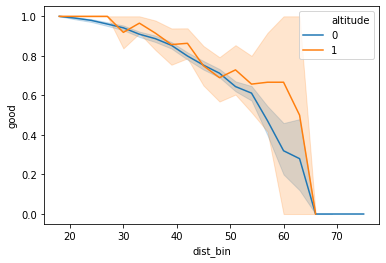

In [38]:
df_ = df.copy()
df_['dist_bin'] = 3*round(df_['dist']/3)
sns.lineplot(x='dist_bin', y='good', hue='altitude', data=df_)

## Pair

We filter for away kicks at altitude and greater than 45 yards.

In [60]:
df_altitude = df[(df['altitude']==1) & (df['away_game']==1) & (df['dist']>=45)]
df_altitude = df_altitude.fillna({'form':'bfill'})
df_altitude

We find paired kicks at sea-level in the original dataset.

In [146]:
def get_mask(data, row, ddist=4, dwind=6, dtemp=10, dyear=2, dpres=2, dkicks=150, dseas=3, dage=3):
    mask = (data['altitude']!=row['altitude']) &\
           (abs(data['kicks']-row['kicks'])<=dkicks) &\
           (abs(data['seasons']-row['seasons'])<=dseas) &\
           (abs(data['age']-row['age'])<=dseas) &\
           (abs(data['dist']-row['dist'])<=ddist) &\
           (abs(data['wind']-row['wind'])<=dwind) &\
           (abs(data['temperature']-row['temperature'])<=dtemp) &\
           (abs(data['year']-row['year'])<=dyear) &\
           (data['postseason']==row['postseason']) &\
           (data['turf']==row['turf']) &\
           (data['iced']==row['iced']) &\
           (data['away_game']==row['away_game']) &\
           (data['precipitation']==row['precipitation']) &\
           (abs(data['pressure']-row['pressure'])<=dpres)
    return mask

def get_diff(df, row):
    for i in row.index:
        if not isinstance(row[i],str):
            df[i+'_d'] = df[i].sub(row[i]).abs()
    return df

In [147]:
sealevel = {}
for index, row in df_altitude.iterrows():
    mask = get_mask(df, row)
    df_choices = get_diff(df[mask],row).sort_values(['dist_d','year_d','kicks_d','wind_d','temperature_d','seasons_d','age_d'])
    for i, choice in df_choices.iterrows():
        if i not in sealevel:
            choice['match_pid'] = index
            sealevel[i] = choice
            break
print(len(df_altitude)-len(sealevel), 'are missing matches.')
df_sealevel = pd.DataFrame.from_dict(sealevel, orient='index').sort_values(['dist_d','year_d','seasons_d'])
df_sealevel

26 are missing matches.


,fkicker,good,dist,year,seasons,temperature,home_team,stadium,team,XP,...,wind_d,away_game_d,postseason_d,iced_d,turf_d,precipitation_d,pressure_d,form_d,kicks_d,match_pid
279219,AV-0400,0,46,2006,11,31,NE,Gillette Stadium,IND,0,...,4,0,0,0,0,0,1,0.104478,65,299646
432650,MC-3000,1,56,2010,4,69,PHI,Lincoln Financial Field,GB\r,0,...,0,0,0,0,0,0,0,0.161130,17,444935
516305,NN-0200,1,51,2011,7,56,OAK,O.co Coliseum Oakland,SD\r,0,...,2,0,0,0,0,0,1,0.189779,23,486829
504391,NF-0300,1,45,2011,5,53,WAS,FedEx Field,NYJ,0,...,2,0,0,0,0,0,1,0.086652,1,498700
112881,DA-0300,0,48,2002,5,64,SF,3COM Park,PHI,0,...,5,0,0,0,0,0,0,0.183031,15,98275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600189,NF-0300,1,54,2013,7,54,CAR,Bank of America Stadium,NYJ,0,...,4,0,0,0,0,0,1,0.183450,11,508096
703154,CP-0575,1,48,2016,3,86,MIA,Sun Life Stadium,CLE,0,...,3,0,0,0,0,0,0,0.205854,73,654422
634760,SS-3100,1,49,2014,10,25,TEN,LP Field,PIT,0,...,3,0,0,0,0,0,0,0.078134,12,692602
530173,MB-4600,1,53,2012,11,52,WAS,FedEx Field,ATL,0,...,4,0,0,0,0,0,1,0.063799,95,469364


We are missing several matches, but I'm not willing to relax any of the parameters any further.

In [148]:
missing = df_altitude.drop(index=df_sealevel['match_pid'])
missing

,fkicker,good,dist,year,seasons,temperature,home_team,stadium,team,XP,...,humid,wind,away_game,postseason,iced,turf,precipitation,pressure,form,kicks
pid,,,,,,,,,,,,,,,,,,,,,
98412,OM-0100,1,53,2002,6,58,DEN,Invesco Field at Mile High,MIA,0,...,0,3,1,0,1,0,0,6,0.647487,247
112842,MV-0100,1,54,2002,5,25,DEN,Invesco Field at Mile High,IND,0,...,1,6,1,0,1,0,1,6,0.629268,218
112854,MV-0100,1,51,2002,5,25,DEN,Invesco Field at Mile High,IND,0,...,1,6,1,0,1,0,1,5,0.696674,219
155428,PE-0100,1,47,2003,4,18,DEN,Invesco Field at Mile High,CHI,0,...,0,8,1,0,1,0,0,2,0.816993,153
199963,SJ-0300,0,48,2004,5,18,DEN,Invesco Field at Mile High,OAK,0,...,1,7,1,0,0,0,1,1,0.947504,193
227963,AV-0400,0,53,2005,10,75,DEN,Invesco Field at Mile High,NE\r,0,...,0,5,1,0,1,0,0,1,0.848384,415
258271,JR-1100,1,47,2005,4,34,DEN,Invesco Field at Mile High,PIT,0,...,0,11,1,1,0,0,0,1,0.948249,121
289389,JB-7100,0,53,2006,4,16,DEN,Invesco Field at Mile High,SEA,0,...,1,0,1,0,0,0,0,1,0.798145,110
289476,JB-7100,1,50,2006,4,16,DEN,Invesco Field at Mile High,SEA,0,...,1,0,1,0,0,0,0,5,0.767729,113


We now filter our altitude dataframe and we have both our datasets ready.

In [149]:
df_altitude = df_altitude.loc[df_sealevel['match_pid'],:]
df_altitude

,fkicker,good,dist,year,seasons,temperature,home_team,stadium,team,XP,...,humid,wind,away_game,postseason,iced,turf,precipitation,pressure,form,kicks
pid,,,,,,,,,,,,,,,,,,,,,
299646,JN-0600,1,46,2006,11,32,DEN,Invesco Field at Mile High,SF\r,0,...,0,4,1,0,0,0,0,1,0.948104,385
444935,NF-0300,1,56,2010,4,73,DEN,Invesco Field at Mile High,NYJ,0,...,0,4,1,0,0,0,0,1,0.903753,94
486829,NN-0200,1,51,2011,7,52,DEN,Sports Authority Field at Mile High,SD\r,0,...,0,6,1,0,0,0,0,2,0.93081,37
498700,NF-0300,1,45,2011,5,54,DEN,Sports Authority Field at Mile High,NYJ,0,...,0,3,1,0,0,0,0,2,0.523415,139
98275,OM-0100,0,48,2002,6,58,DEN,Invesco Field at Mile High,MIA,0,...,0,3,1,0,0,0,0,1,0.791373,246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508096,RG-1500,1,57,2011,7,50,DEN,Sports Authority Field at Mile High,CHI,0,...,0,7,1,0,0,0,0,2,0.749496,211
654422,JT-3950,1,52,2015,4,88,DEN,Sports Authority Field at Mile High,BAL,0,...,0,13,1,0,1,0,0,1,0.917864,115
692602,MN-0800,0,45,2015,11,16,DEN,Sports Authority Field at Mile High,CIN,0,...,1,6,1,0,0,0,0,1,0.892411,261


## Model

* We treat our true population proportion for each dataset as a random variable with Beta distribution.
* We assign a prior Beta for both proportions using the sample population proportion.

In [199]:
p_hat = df[df['dist']>=45]['good'].mean()
# beta_ = 2
# alpha_ = int(round(p_hat*beta_/(1-p_hat)))
alpha_ = 12
beta_ = int(round(alpha_*(1-p_hat)/p_hat))
print(f'alpha: {alpha_}, beta: {beta_}')

alpha: 12, beta: 6


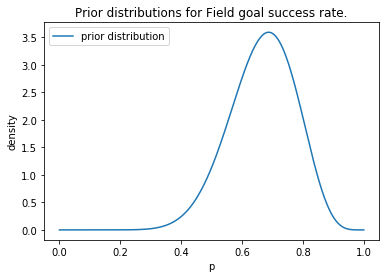

In [200]:
x = np.linspace(0,1,500)
plt.plot(x, beta(alpha_, beta_).pdf(x), label='prior distribution')
plt.xlabel('p')
plt.ylabel('density')
plt.title('Prior distributions for Field goal success rate.')
plt.legend()
plt.show()

In [201]:
from scipy.stats import beta
posterior_sea = beta(alpha_ + df_sealevel['good'].sum(), beta_ + len(df_sealevel) - df_sealevel['good'].sum())
posterior_alt = beta(alpha_ + df_altitude['good'].sum(), beta_ + len(df_altitude) - df_altitude['good'].sum())
samples = 20000
samples_posterior_sea = posterior_sea.rvs(samples)
samples_posterior_alt = posterior_alt.rvs(samples)

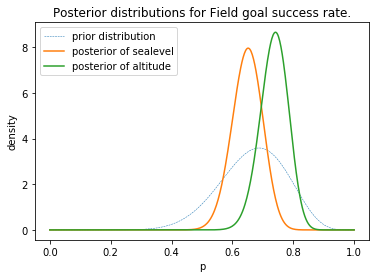

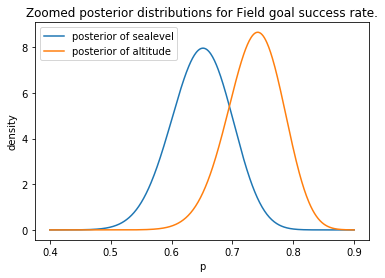

In [207]:
x = np.linspace(0,1,500)
plt.plot(x, beta(alpha_, beta_).pdf(x), label='prior distribution', linestyle='dashed', linewidth=0.5)
plt.plot(x, posterior_sea.pdf(x), label='posterior of sealevel')
plt.plot(x, posterior_alt.pdf(x), label='posterior of altitude')
plt.xlabel('p')
plt.ylabel('density')
plt.title('Posterior distributions for Field goal success rate.')
plt.legend()
plt.show()

x = np.linspace(0.4,0.9,500)
plt.plot(x, posterior_sea.pdf(x), label='posterior of sealevel')
plt.plot(x, posterior_alt.pdf(x), label='posterior of altitude')
plt.xlabel('p')
plt.ylabel('density')
plt.title('Zoomed posterior distributions for Field goal success rate.')
plt.legend()
plt.show()

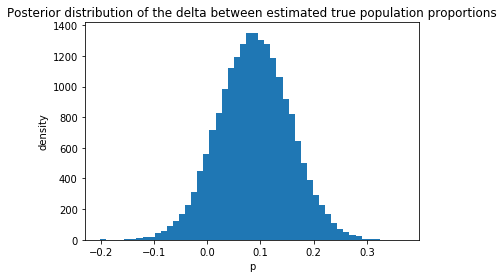

90 % likely that altitude has a greater true population proportion of converted field goals.
0.09 is the median difference, with credible interval of (-0.04,0.22).


In [231]:
posterior_diff = samples_posterior_alt - samples_posterior_sea

plt.hist(posterior_diff, histtype='stepfilled', bins=50)
plt.xlabel('p')
plt.ylabel('density')
plt.title('Posterior distribution of the delta between estimated true population proportions')
plt.show()
print(int((samples_posterior_alt>samples_posterior_sea).mean()*100), r'% likely that altitude has a greater true population proportion of converted field goals.')

from scipy.stats import bayes_mvs
center, _, std = bayes_mvs(posterior_diff, alpha=0.95)
print(f'{round(center.statistic,2)} is the median difference, with credible interval of ({round(center.statistic-1.96*std.statistic,2)},{round(center.statistic+1.96*std.statistic,2)}).')

We are sometimes interested in relative increase. For instance, the difference between 0.6 and 0.7 is relatively larger than the difference between 0.7 and 0.8.
We calculate relative increase of our treatment (altitude) over control (sea-level) using our posterior distributions.

62 % likely relative lift is greater than 10%.
0.14 is the median relative lift, with credible interval of (-0.08,0.37).


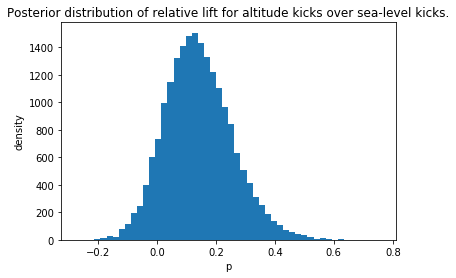

In [233]:
posterior_relative = (samples_posterior_alt-samples_posterior_sea)/samples_posterior_sea
plt.hist(posterior_relative, histtype='stepfilled', bins=50)
plt.xlabel('p')
plt.ylabel('density')
plt.title('Posterior distribution of relative lift for altitude kicks over sea-level kicks.')
print(int((posterior_relative>0.1).mean()*100), r'% likely relative lift is greater than 10%.')

center, _, std = bayes_mvs(posterior_relative, alpha=0.95)
print(f'{round(center.statistic,2)} is the median relative lift, with credible interval of ({round(center.statistic-1.96*std.statistic,2)},{round(center.statistic+1.96*std.statistic,2)}).')

## Conclusions

* Given our model, we are 90% sure that kicking at altitude is an advantage.
* The 95% credible interval for the difference in true population proportion is (-0.04,0.22).
* The median value of relative lift is 14%.
* The 95% credible interval for relative lift between true proportions is (-0.08,0.37).